# Data exploration and preprocessing

- The intention of this notebook is to explore the data to determine the distribution of each one of the features. Also, here is performed the preprocessing of the database, splitting the database in the train and test datasets, normalizing the data and applying different approaches of dimensionality reduction techniques

## Authors
- Giménez López, Antonio  
- Izquierdo Álvarez, Mario 
- Núñez Sánchez, Fernando  
- Romero Romero, Martín  

In [1]:
#INSTALL PACKAGES
#=import Pkg;
Pkg.add("Plots")
Pkg.add("ScikitLearn")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("MLDataUtils")
Pkg.add("StatsBase")
Pkg.add("HDF5")=#

In [2]:
# Including Modules
push!(LOAD_PATH, "./modules")

4-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "./modules"

In [3]:
using Random

#Random seed for reproducibility
Random.seed!(42)

TaskLocalRNG()

### 1. Preprocessing the data

#### 1.1. Loading the dataset

In [4]:
using CSV
using DataFrames

##READ DATA
path="data/train.csv"
data = CSV.File(path, header=false) |> DataFrame
describe(data)


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Nothing,InlineSt…,Nothing,InlineSt…,Int64,DataType
1,Column1,,1000,,battery_power,0,String15
2,Column2,,0,,blue,0,String7
3,Column3,,0.5,,clock_speed,0,String15
4,Column4,,0,,dual_sim,0,String15
5,Column5,,0,,fc,0,String3
6,Column6,,0,,four_g,0,String7
7,Column7,,10,,int_memory,0,String15
8,Column8,,0.1,,m_dep,0,String7
9,Column9,,100,,mobile_wt,0,String15


In [5]:
#Create input and output data
total_data=Matrix(data[2:end,1:end]);
input_data=Matrix(data[2:end,1:end-1]);
output_data=Vector(data[2:end,end]);

#Convert input data to float
total_data=parse.(Float32,total_data);
input_data=parse.(Float32,input_data);

#### 1.2. Dataset features analysis

##### Histogram

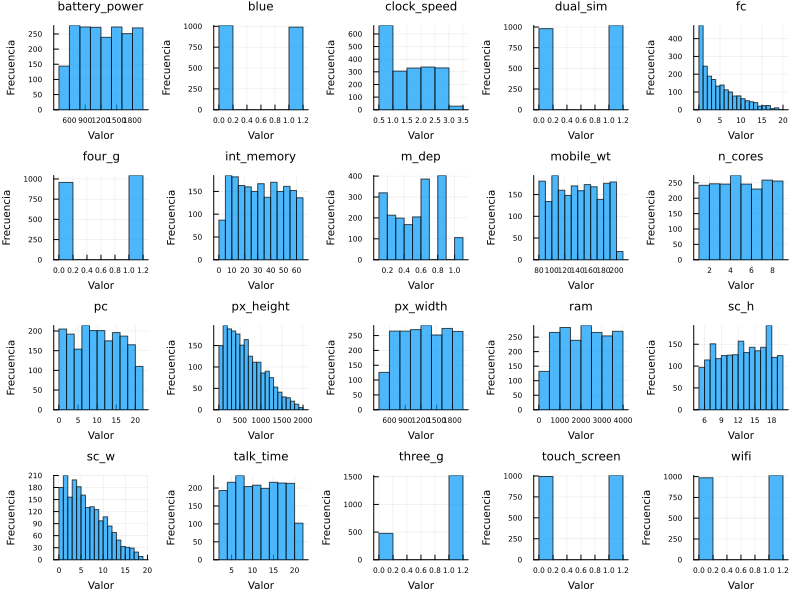

In [6]:
using Plots
using StatsBase

# Create an empty array to store the histograms
histogramas = []

# Calculate the histograms for each feature

for i in 1:size(input_data, 2)
    push!(histogramas, histogram(input_data[:, i], title=data[1,i], xlabel="Valor", ylabel="Frecuencia", alpha=0.7))
end

# Show the histograms
plot(histogramas..., legend=false,size=(800, 600),guidefontsize=7, tickfontsize=5, legendfontsize=7,titlefontsize=8)

#### 1.3. Spliting the dataset in train input, test input, train output and test output

In [7]:
using Preprocessing
using ModelSelection

In [8]:
unique(output_data)

4-element Vector{String15}:
 "1"
 "2"
 "3"
 "0"

In [9]:
#Performing the oneHotEncoding
#output_data=oneHotEncoding(output_data);

# Split the data in train and test dataset
N = size(input_data, 1)
train_indices, test_indices = holdOut(N, 0.2)  # 20% for testing, 80% for training

oneHotOuts = oneHotEncoding(vec(output_data)) # To train and test the final models, all targets must be oneHot encoded together. This is to avoid unique() problems

train_input = input_data[train_indices, :];
train_output = vec(output_data[train_indices, :]);
train_output_oneHot = oneHotOuts[train_indices, :];

test_input = input_data[test_indices, :];
test_output = vec(output_data[test_indices, :]);
test_output_oneHot = oneHotOuts[test_indices, :];

In [10]:
# Check the size of the data
println("Total input size: ", size(input_data))
println("Train input size: ", size(train_input))
println("Train output size: ", size(train_output))
println("Test input size: ", size(test_input))
println("Test output size: ", size(test_output))

Total input size: (2000, 20)
Train input size: (1600, 20)
Train output size: (1600,)
Test input size: (400, 20)
Test output size: (400,)


#### 1.4. Normalizing the data

As none of the features follow a normal distribution and there are no missing values or outliers. It will be performed the minMax normalization.

In [11]:
# Prepare input data
min,max =calculateMinMaxNormalizationParameters(train_input)
train_input = normalizeMinMax!(train_input,(min,max))
@assert isa(train_input, Array{<:Float32,2})

# Normalize the test data using the parameters calculated for the train data
test_input = normalizeMinMax!(test_input,(min,max))
@assert isa(test_input, Array{<:Float32,2})

### 2. Dimensionality Reduction

In this project, in addition of testing what machine learning techniques achieve the best model to predict the price range of a specific mobile, it will be also tested which of the three approaches applied here is most useful for the database on which we are going to train these models.

#### 2.1. No feature reduction

In [12]:
# Storing the data in a new variable
ndr_train_input = train_input;
ndr_train_output = train_output;

ndr_test_input = test_input;
ndr_test_output = test_output;

In [13]:
# using HDF5

# # # Save the data in a HDF5 file

# h5open("./NDR/ndr_data.h5", "w") do file
#     write(file, "train_input", ndr_train_input)
#     write(file, "train_tags", ndr_train_output)
#     write(file, "test_input", ndr_test_input)
#     write(file, "test_tags", ndr_test_output)
#     write(file, "train_tags_oneHot", convert(Array{Int}, train_output_oneHot))
#     write(file, "test_tags_oneHot", convert(Array{Int}, test_output_oneHot))
# end


#### 2.2. PCA

In [14]:
using ScikitLearn

@sk_import decomposition:PCA

#Define the PCA object and the number of componentes that are desired
pca = PCA(0.95) # 90% of total variability

#Ajust the Vector acording to the train data
ScikitLearn.fit!(pca, train_input)

#Once it is ajusted it can be used to transform the data
pca_train_input = pca.transform(train_input)
pca_test_input = pca.transform(test_input)

400×17 Matrix{Float32}:
 -0.542307   0.619174   -0.244055   …  -0.063458     0.496296   -0.244619
 -0.512072  -0.607173    0.218924       0.072532    -0.163179   -0.0847101
 -0.432031   0.164164   -0.349193      -0.0880469   -0.507096    0.459818
 -0.510597   0.166096   -0.785019      -0.365211     0.175884   -0.366784
  0.877962   0.092226   -0.773117      -0.783613    -0.14371     0.132671
 -0.553514   0.599681   -0.298024   …   0.324501     0.0900135  -0.0193068
 -0.476084   0.119003    0.568357      -0.56552      0.0771268  -0.0843576
  0.344835   0.122137    0.598153       0.0166148   -0.342368    0.0156071
 -0.512135  -0.585781    0.21227        0.0396746    0.0939812  -0.348554
 -0.47211    0.110579   -0.415208       0.108381    -0.147175    0.257231
  0.260812  -0.649376   -0.585694   …  -0.164294     0.016399   -0.349718
 -0.493824  -0.563503   -0.65129       -0.434112    -0.0780861   0.174287
  0.881997  -0.0532626  -0.510993       0.0734667    0.0080321   0.229746
  ⋮       

Number of components: 17
Variance of each component: Float32[0.13100424, 0.10188556, 0.09826965, 0.096149296, 0.08897625, 0.046954446, 0.045633413, 0.042792443, 0.041035313, 0.039847765, 0.037417766, 0.03515269, 0.034025457, 0.03277325, 0.032518994, 0.03228599, 0.030297961]
Total variance: 0.96702045


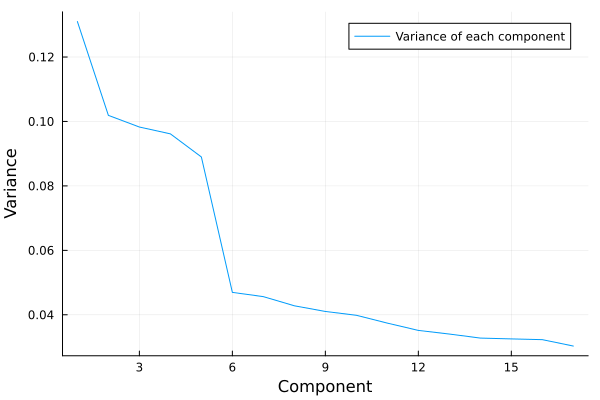

In [15]:
#Check the variance of each component

println("Number of components: ", length(pca.explained_variance_ratio_))
println("Variance of each component: ", pca.explained_variance_ratio_)
println("Total variance: ", sum(pca.explained_variance_ratio_))

#Plot the variance of each component
using Plots
plot(pca.explained_variance_ratio_, label="Variance of each component", xlabel="Component", ylabel="Variance")


With 17 principal components we conserve the 96.67% of the variability of the dataset.

In [16]:
using Plotting

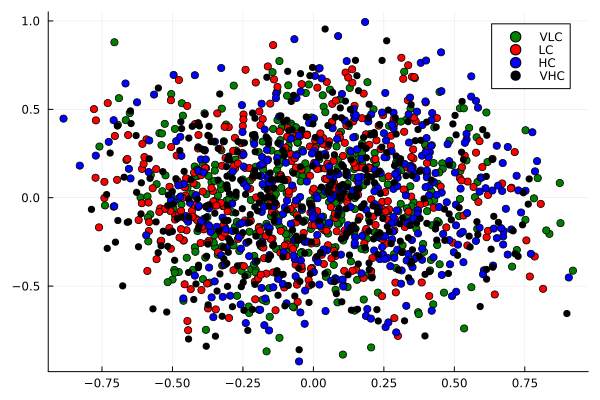

In [17]:
draw_results(pca_train_input, oneHotEncoding(train_output),(7,8),[:green, :red, :blue, :black], ["VLC", "LC", "HC", "VHC"])

There does not appear to have been a separation of classes into clusters.

In [18]:
# Finally we have:

pca_train_input;
pca_train_output = train_output;

pca_test_input;
pca_test_output = test_output;

In [19]:
# using HDF5

# # Save the data in a HDF5 file

# h5open("./PCA/pca_data.h5", "w") do file
#     write(file, "train_input", pca_train_input)
#     write(file, "train_tags", pca_train_output)
#     write(file, "test_input", pca_test_input)
#     write(file, "test_tags", pca_test_output)
#     write(file, "train_tags_oneHot", convert(Array{Int}, train_output_oneHot))
#     write(file, "test_tags_oneHot", convert(Array{Int}, test_output_oneHot))
# end


#### 2.3. Feature selection 

In [20]:
# Calculating the correlation matrix
correlation_matrix = cor(total_data);

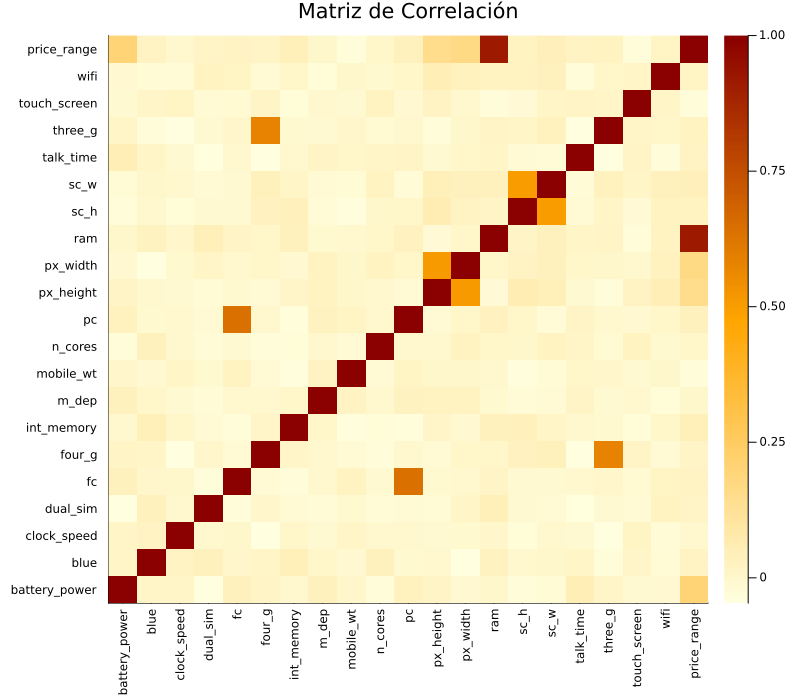

In [21]:
using Plots

# Define the variable names
variable_names = ["$(i)" for i in data[1,:]]

heatmap(correlation_matrix, 
    title="Matriz de Correlación", 
    xticks=(1:size(correlation_matrix, 2), variable_names), 
    yticks=(1:size(correlation_matrix, 1), variable_names),
    xrotation=90,
    size=(800, 700),
    color=:heat,
    cbar=true)

Analyzing the heat map, it is discovered that the variables that have the most correlation with the price of the mobile phone are these 4, sorted in descending order:
1. RAM
2. Battery Power
3. Screen Height
4. Screen Width

In [22]:
# We isolate the data of the 4 classes with higher correlation with the output

fs_train_input = train_input[:, [1, 12, 13, 14]];
fs_train_output = train_output;

fs_test_input = test_input[:, [1, 12, 13, 14]];
fs_test_output = test_output;


In [23]:
# using HDF5

# h5open("./FSelection/fs_data.h5", "w") do file
#     write(file, "train_input", fs_train_input)
#     write(file, "train_tags", fs_train_output)
#     write(file, "test_input", fs_test_input)
#     write(file, "test_tags", fs_test_output)
#     write(file, "train_tags_oneHot", convert(Array{Int}, train_output_oneHot))
#     write(file, "test_tags_oneHot", convert(Array{Int}, test_output_oneHot))
# end
